In [20]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import cv2
from random import randint
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split
# from models import build_model
from skimage.transform import resize
from losers import combine_loss
from metrics import dice_coef
from helpers import create_dataset_from_tfrecord, create_dataset_from_directory, create_deserializer
# from keras.preprocessing.image import load_img
# from keras import Model
# from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from keras.models import load_model
# from keras.optimizers import Adam
# from keras.utils.vis_utils import plot_model
# from keras.preprocessing.image import ImageDataGenerator
# from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from helpers import create_tfrecords, get_reshaper
from tqdm import tqdm_notebook
import tensorflow as tf
from util import create_coverage_stratas, get_paths

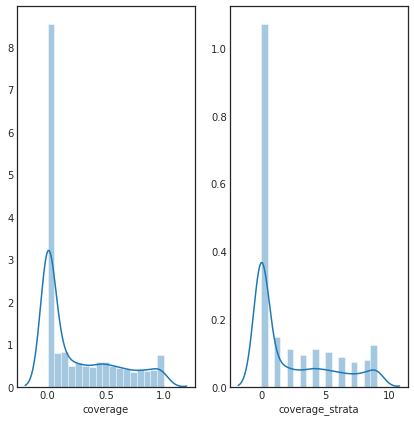

In [22]:
images_salt_stratas = pd.read_csv('/content/drive/My Drive/stratified_data.csv')

f, ax = plt.subplots(1,2, figsize=(7,7))
sns.distplot(images_salt_stratas['coverage'], ax=ax[0])
sns.distplot(images_salt_stratas['coverage_strata'], ax=ax[1])


In [23]:
images_salt_stratas.head()

,id,mask,img,coverage,coverage_strata
0,bf05a52a6b,./drive/My Drive/tgs/train/masks/bf05a52a6b.png,./drive/My Drive/tgs/train/images/bf05a52a6b.png,0.000196,0
1,bfbea83faa,./drive/My Drive/tgs/train/masks/bfbea83faa.png,./drive/My Drive/tgs/train/images/bfbea83faa.png,0.409960,4
2,bfa7ee102e,./drive/My Drive/tgs/train/masks/bfa7ee102e.png,./drive/My Drive/tgs/train/images/bfa7ee102e.png,0.960396,9
3,bfac8e63cb,./drive/My Drive/tgs/train/masks/bfac8e63cb.png,./drive/My Drive/tgs/train/images/bfac8e63cb.png,0.000000,0
4,bf76c8aff3,./drive/My Drive/tgs/train/masks/bf76c8aff3.png,./drive/My Drive/tgs/train/images/bf76c8aff3.png,0.128223,1


In [0]:
train_index, valid_index = train_test_split(images_salt_stratas.index, test_size=0.2, stratify=images_salt_stratas.coverage_strata, random_state=1337)

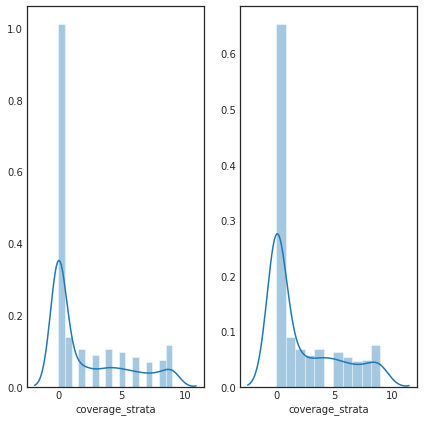

In [25]:
f, ax = plt.subplots(1, 2, figsize=(7,7))
sns.distplot(images_salt_stratas.loc[train_index].coverage_strata, ax=ax[0])
sns.distplot(images_salt_stratas.loc[valid_index].coverage_strata, ax=ax[1])

In [0]:
train_imgs, valid_imgs = train_test_split([(i, m) for i, m in zip(images_salt_stratas['img'].values, images_salt_stratas['mask'].values)], test_size=0.2, stratify=images_salt_stratas.coverage_strata, random_state=1337)

In [27]:
train_imgs[0]

('./drive/My Drive/tgs/train/images/a37249665e.png',
 './drive/My Drive/tgs/train/masks/a37249665e.png')

In [10]:
    create_tfrecords(train_imgs, '/content/drive/My Drive/train_records', [get_reshaper()])
    create_tfrecords(valid_imgs, '/content/drive/My Drive/test_records', [get_reshaper()])

KeyboardInterrupt: ignored

In [0]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    pool1 = tf.keras.layers.Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    pool2 = tf.keras.layers.Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    pool3 = tf.keras.layers.Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(0.5)(pool4)

    # Middle
    convm = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(0.5)(uconv4)
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])
    uconv3 = tf.keras.layers.Dropout(0.5)(uconv3)
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])
    uconv2 = tf.keras.layers.Dropout(0.5)(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])
    uconv1 = tf.keras.layers.Dropout(0.5)(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    # uconv1 = tf.keras.layers.Dropout(0.5)(uconv1)
    output_layer = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(uconv1)

    return output_layer

In [0]:
input_layer = tf.keras.layers.Input((128, 128, 1))
output_layer = build_model(input_layer, 16)
model = tf.keras.models.Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer=tf.train.AdamOptimizer(0.0000001), metrics=["accuracy"])

In [0]:
train_ds = create_dataset_from_directory('/content/drive/My Drive/train_records', create_deserializer())
test_ds = create_dataset_from_directory('/content/drive/My Drive/test_records', create_deserializer())

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 20
# train_ds = train_ds.batch(20)


In [0]:
# def normalize(img, mask):
#   return img / 255.0, mask / 255.0


In [0]:
#     files = tf.data.Dataset.list_files("/content/drive/My Drive/train_records/*.tfrecord")
#     dataset = files.apply(tf.contrib.data.parallel_interleave(
#         tf.data.TFRecordDataset, cycle_length=4))
#     # dataset = dataset.map(map_func=decode_func)
#     # dataset = dataset.batch(batch_size=batch_size)
#     dataset = dataset.map(map_func=create_deserializer(), num_parallel_calls=4)
# #     dataset = dataset.map(map_func=normalize, num_parallel_calls=4)

#     dataset = dataset.batch(batch_size=20)
#     dataset = dataset.prefetch(40)

In [33]:
train_ds

<DatasetV1Adapter shapes: ((?, 128, 128, 1), (?, 128, 128, 1)), types: (tf.float64, tf.float64)>

In [34]:
model.fit(train_ds,
                    epochs=1,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

     67/Unknown - 146s 2s/step - loss: 0.6873 - acc: 0.7609

KeyboardInterrupt: ignored

In [0]:
img = cv2.imread('/content/drive/My Drive/tgs/train/images/fff987cdb3.png', cv2.IMREAD_GRAYSCALE)
img = (cv2.resize(img, (128,128), interpolation=cv2.INTER_CUBIC).astype(np.float64) / 255.0).reshape((1,128,128,1))

In [0]:
a = model.predict(img)

In [0]:
a = (a.reshape((128,128))) * 255.0


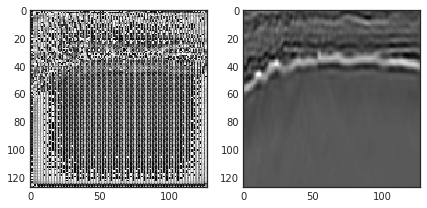

In [117]:
f, ax = plt.subplots(1, 2, figsize=(7,7))
plt.imshow(a, cmap='gray')

ax[0].imshow(a.astype(np.uint8), cmap='gray')
ax[1].imshow((img * 255.0).reshape((128,128)).astype(np.uint8), cmap='gray')

In [17]:
iterator = train_ds.make_one_shot_iterator()
next_element = iterator.get_next()

W0812 12:01:53.569370 140140232124288 deprecation.py:323] From <ipython-input-17-41b483c30021>:1: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [0]:
with tf.Session() as sess:
  a = sess.run(next_element)

In [19]:
a[1][0]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])